In this notebook we will be writing our first CA simulator code, which we will subsequently build off of to demonstrate various aspects of scientific programming in Python. The code here will use no abstraction through functions or classes, and will not use any numpy. We will try our best though to follow the PEP8 style guide and make this code as readable as we can. 

Below we use the jupyter notebook as a development workspace, where we can try various approaches and run small tests to make sure code we write is doing what we want it to do. At the end we will collect all the pieces and put them in a single cell which will act as our code base script. Executing that cell will produce and plot a spacetime field of a given shape using the given ECA rule number.

**Note that I am using Python 2.7. I know a lot of people are using Python 3, so I will try to make print statements the only thing that needs to be changed for those using Python 3. The main difference otherwise will be the use of range and zip. Python 3 uses iterator versions of these by default. To use the iterator versions in Python 2.7 (which you should), use xrange instead of range and izip instead of zip (izip needs to be imported from itertools).**

First thing is to import all packages we will be using, which here is just the random package for random initial conditions and matplotlib to plot spacetime fields

In [1]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

A CA spacetime field is uniquely determined by the initial condition, the update rule (i.e. the lookup table), the number of time steps the update rule is applied, and the boundary conditions. 

We will only use periodic boundary conditions so the three pieces we need for the simulator are an initial condition, an update time, and the lookup table. 

Let's start by producing a random binary string of a given length for our initial condition.

In [2]:
length = 20

There are several ways to create our initial condition without using numpy.

In [3]:
# first, let's create an empty list and then build it up with random samples of (0,1)
initial_condition_1 = []
for i in range(length):
    initial_condition_1.append(random.randint(0,1))
print initial_condition_1

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


The above is intuitive, but since it has to dynamically allocate memory space to the initial condition list as it grows it is not as efficient as it could be (it doesn't really make much of a difference for such a small array). 

In [4]:
# next then, we can create a list of the given length, then populate it with random samples as so. 
initial_condition_2 = [0] * length 
for i in range(length):
    initial_condition_2[i] = random.randint(0,1)
print initial_condition_2

[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]


In [5]:
# The more Pythonic way to do this is by using a list comprehension
initial_condition_3 = [random.randint(0,1) for _ in range(length)]
print initial_condition_3

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


Create a variable for how many time steps to evolve our CA. 

In [6]:
time = 20

Those were easy. Now we have to make the lookup table, which is less trivial. It may not be immediately obvious what data structure we should use for this. The lookup table maps neighborhoods to updated site values, so we will use a dictionary which maps keys to values. 

The lookup table is defined by the CA rule number, following the Wolfram numbering convention. So first we need to convert our integer rule number to binary. We also need a list of the 8 possible neighborhoods given in lexicographical order. Since these will be the keys for our lookup table dictionary, they need to be tuples

In [7]:
rule_number = 18

In [8]:
neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

In [9]:
# first we will try bin()
print bin(rule_number)
# cut off the fisrt two characters (0b), and flip the remaining string around so it is the proper order
print bin(rule_number)[2:][::-1]

0b10010
01001


Notice that the result is not 8 characters long. We need to pad it with zeros on the right so that all the neighborhoods have an output they map to. 

In [10]:
# A simple, but not Pythonic, first thing we could do is this
in_binary_1 = bin(rule_number)[2:][::-1]
binary_length = len(in_binary_1)
if binary_length != 8:
    padding = 8 - binary_length
    in_binary_1 = in_binary_1 + '0'*padding
print in_binary_1

01001000


We can now build the lookup table dictionary

In [11]:
lookup_table_1 = {}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary_1[i]
    lookup_table_1.update({key:val})
for key, val in lookup_table_1.items():
    print key, '-->', val

(0, 1, 1) --> 0
(0, 0, 0) --> 0
(1, 1, 0) --> 0
(1, 0, 0) --> 1
(0, 1, 0) --> 0
(0, 0, 1) --> 1
(1, 1, 1) --> 0
(1, 0, 1) --> 0


We can do both of the above steps in a more Pythonic way using a try, except statement. This way we don't need to pad the binary conversion, since we know if there is an index error it would needed to be padded with 0. 

In [12]:
# if we try to create the dictionary without padding we get an IndexError
in_binary_2 = bin(rule_number)[2:][::-1]
lookup_table_2 ={}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary_2[i]
    lookup_table_2.update({key:val})

IndexError: string index out of range

In [13]:
# use try, except statement to make val a 0 if the index runs over, where we had to pad before
in_binary_2 = bin(rule_number)[2:][::-1]
lookup_table_2 ={}
for i in range(8):
    key = neighborhoods[i]
    try:
        val = in_binary_2[i]
    except IndexError:
        val = '0'
    lookup_table_2.update({key: val})
for key, val in lookup_table_2.items():
    print key, '-->', val

(0, 1, 1) --> 0
(0, 0, 0) --> 0
(1, 1, 0) --> 0
(1, 0, 0) --> 1
(0, 1, 0) --> 0
(0, 0, 1) --> 1
(1, 1, 1) --> 0
(1, 0, 1) --> 0


Better still, let's use string formatting to convert the rule number to binary and automatically pad with 0s as needed, then use zip and dict to create the lookup table.

In [14]:
in_binary_3 = '{:{fill}{align}{width}b}'.format(rule_number, fill='0', align='>', width='8')
print in_binary_3

00010010


In [15]:
# since the string formatting also gives the binary result in the opposite order of what we want, use the 
# reversed function in zip, so that it iterates through in the order we need
lookup_table_3 = dict(zip(neighborhoods, reversed(in_binary_3)))

for key, val in lookup_table_3.items():
    print key, '-->', val

(0, 1, 1) --> 0
(1, 1, 0) --> 0
(1, 0, 0) --> 1
(0, 0, 1) --> 1
(1, 0, 1) --> 0
(0, 0, 0) --> 0
(0, 1, 0) --> 0
(1, 1, 1) --> 0


We now have all the pieces we need, so let's put them together to make a spacetime field

In [16]:
# spacetime field will be a list of lists, so that spacetime_field[t] is the lattice configuration at time t
# initialize with the initial condition
spacetime_field = [initial_condition_3]

In [17]:
print spacetime_field
print spacetime_field[0]

[[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]]
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


In [18]:
# for implementation of the update rule, we will need a variable to keep track of the current configuration

# We have to be careful though to COPY the list, and not just use the equals sign
current_configuration = initial_condition_3[:]

In [19]:
print current_configuration

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


In [20]:
# we will also need a new_configuration placeholder 
new_configuration = []
# iterate through the current configuration, get the neighborhood, and apply the lookup table
for i in range(len(current_configuration)):
    
    neighborhood = (current_configuration[(i-1)], 
                    current_configuration[i], 
                    current_configuration[(i+1)%length]) # use % for periodic boundary condition
    
    new_configuration.append(int(lookup_table_3[neighborhood]))
print new_configuration

[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [21]:
# now just do the above for the given number of time steps
for t in range(time):
    new_configuration = []
    for i in xrange(len(current_configuration)):
        
        neighborhood = (current_configuration[(i-1)], 
                        current_configuration[i], 
                        current_configuration[(i+1)%length])
        
        new_configuration.append(int(lookup_table_3[neighborhood]))
    # update the current configuration    
    current_configuration = new_configuration
    # add the new configuration to the spacetime field
    spacetime_field.append(new_configuration)

Take a look out our spacetime field

In [22]:
for config in spacetime_field:
    print config

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
[0, 0, 1, 1, 0, 1, 0, 1,

Finally, make a spacetime diagram

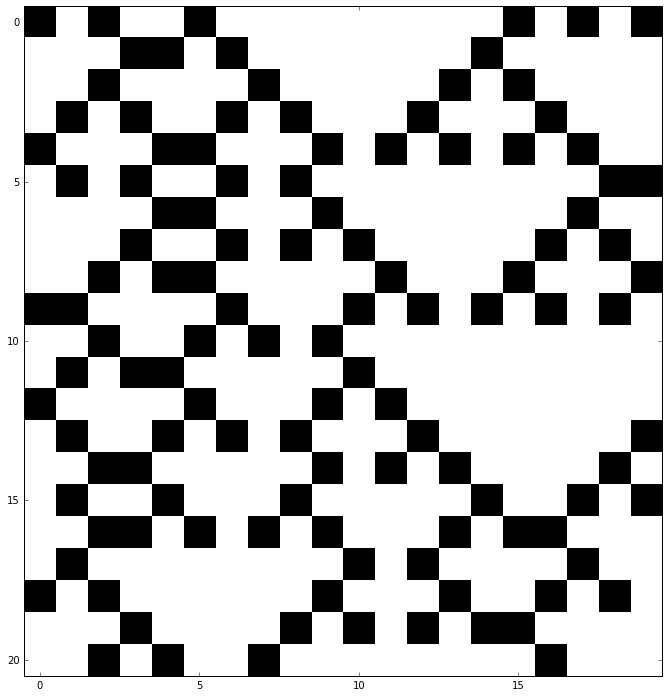

In [23]:
plt.figure(figsize=(12,12))
plt.imshow(spacetime_field, cmap=plt.cm.Greys, interpolation='nearest')
plt.show()

Looks like rule 18!

We now collect all the final results so that we can run everything in a single cell (like a .py script) to chose our parameters and create the corresponding spacetime diagram. 

To maximize spaghettiness and make it look gross, I'm going to use the non-pythonic implementations from above, so if you are skipping down to this part be sure to go back up and see some better code.

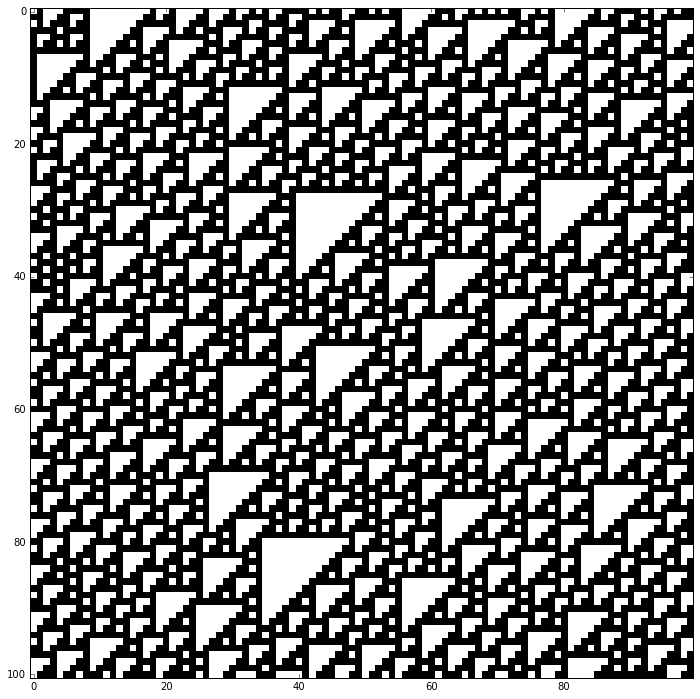

In [2]:
rule_number = 110
length = 100
time = 100 

# make the initial condition
initial_condition = []
for i in range(length):
    initial_condition.append(random.randint(0,1))

# create list of neighborhood tuples in lex. order
neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

# convert the rule number to binary and padd with 0s as needed
in_binary = bin(rule_number)[2:][::-1]
binary_length = len(in_binary)
if binary_length != 8:
    padding = 8 - binary_length
    in_binary = in_binary + '0'*padding

# create the lookup table dictionary
lookup_table = {}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary[i]
    lookup_table.update({key:val})
    
# initialize spacetime field and current configuration
spacetime_field = [initial_condition]
current_configuration = initial_condition[:]

# apply the lookup table to evolve the CA for the given number of time steps
for t in range(time):
    new_configuration = []
    for i in range(len(current_configuration)):
        
        neighborhood = (current_configuration[(i-1)%length], 
                        current_configuration[i], 
                        current_configuration[(i+1)%length])
        
        new_configuration.append(int(lookup_table[neighborhood]))
        
    current_configuration = new_configuration
    spacetime_field.append(new_configuration)
    
# plot the spacetime field diagram
plt.figure(figsize=(12,12))
plt.imshow(spacetime_field, cmap=plt.cm.Greys, interpolation='nearest')
plt.show()